In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import os
import joblib
import pickle
import mlflow.sklearn

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
df = pd.read_csv(r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\df.csv", sep=",")

In [6]:
# Eliminar 18 Columnas
columns_to_drop = ['Unnamed: 0', 'origin_id', 'construction_year', 'first_appearance', 'last_appearance', 'is_exact_address','is_vertical','n_floor', 'has_storage', 'has_garage_included', 'has_common_zones', 'has_terrace', 'has_air_conditioner', 'cardinal_direction_id','has_racket_zone','has_security','direccion','distrito']
df1 = df.drop(columns=columns_to_drop)

In [7]:
def imputar_n_rooms(row):
    if pd.notna(row['n_rooms']):
        return row['n_rooms']
    elif pd.notna(row['description']):
        description = row['description'].lower()
        if 'estudio' in description or 'loft' in description or 'sin divisiones' in description:
            return 0
    return None

df1['n_rooms'] = df1.apply(imputar_n_rooms, axis=1)

In [8]:
df1['n_rooms'].fillna(1, inplace=True)

In [9]:
df1['n_baths'].fillna(1, inplace=True)

In [10]:
indice_fila = df1[df1['n_baths'] == 0.0].index[0]
df1.at[indice_fila, 'n_baths'] = 2.0

In [11]:
indice_fila = df1[df1['n_baths'] == 20.0].index[0]
df1.at[indice_fila, 'n_baths'] = 2.0

In [12]:
indice_fila = df1[df1['n_baths'] == 22.0].index[0]
df1.at[indice_fila, 'n_baths'] = 2.0

In [13]:
indice_fila = df1[df1['n_baths'] == 55.0].index[0]
df1.at[indice_fila, 'n_baths'] = 1.0

In [14]:
keywords = ['garaje', 'garage', 'plaza de parking', 'parking']
condition = df1['description'].str.contains('|'.join(keywords), case=False)
df1['has_garage'] = condition.apply(lambda x: 't' if x else 'f')

In [15]:
df1.loc[df1['tipology'] == 'chalet', 'has_garage'] = 't'

In [16]:
keywords = ['piscina', 'tiene piscina', 'dispone de piscina']
condition = df1['description'].str.contains('|'.join(keywords), case=False)
df1['has_pool'] = np.where(condition, 't', 'f')

In [17]:
condition = (df1['has_elevator'].isnull()) & (df1['description'].str.contains('con ascensor|tiene ascensor', case=False, na=False))
df1.loc[condition, 'has_elevator'] = 't'
condition = (df1['has_elevator'].isnull())
df1.loc[condition, 'has_elevator'] = 'f'

In [18]:
condition = (df1['is_exterior'].isnull()) & (df1['description'].str.contains('exterior|con terraza', case=False, na=False))
df1.loc[condition, 'is_exterior'] = 't'
condition = (df1['is_exterior'].isnull())
df1.loc[condition, 'is_exterior'] = 'f'

In [19]:
df1 = df1.drop(["description", "title", "url"], axis=1)

In [20]:
df1

,area,local_price,replace,replace.1,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior
0,135,3200,40.437687,-3.691055,Piso,1.0,2.0,f,f,t,t
1,250,6000,40.439434,-3.686233,Piso,4.0,4.0,t,t,t,t
2,146,2460,40.468037,-3.708661,Piso,3.0,2.0,t,t,t,t
3,98,3000,40.441212,-3.670406,Piso,3.0,3.0,f,f,f,t
4,125,3675,40.411247,-3.668222,Piso,3.0,2.0,t,t,t,t
...,...,...,...,...,...,...,...,...,...,...,...
6357,45,1450,40.414158,-3.701161,Piso,2.0,1.0,f,f,f,f
6358,30,1250,40.425045,-3.705386,Piso,2.0,1.0,f,f,f,f
6359,73,900,40.392933,-3.736926,Piso,3.0,1.0,t,t,t,t
6360,32,850,40.417221,-3.703297,Piso,0.0,1.0,f,f,t,t


In [21]:
le = LabelEncoder()
df1['tipology'] = le.fit_transform(df1['tipology'])

In [22]:
le = LabelEncoder()
df1['has_garage'] = le.fit_transform(df1['has_garage'])

In [23]:
le = LabelEncoder()
df1['has_pool'] = le.fit_transform(df1['has_pool'])

In [24]:
le = LabelEncoder()
df1['has_elevator'] = le.fit_transform(df1['has_elevator'])

In [25]:
le = LabelEncoder()
df1['is_exterior'] = le.fit_transform(df1['is_exterior'])

In [26]:
scaler = StandardScaler()
columns_to_scale = ['area', 'replace', 'replace.1', 'n_rooms', 'n_baths']
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])

In [27]:
import os
carpeta_mis_documentos = r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES"
if not os.path.exists(carpeta_mis_documentos):
    os.makedirs(carpeta_mis_documentos)
ruta_guardado = os.path.join(carpeta_mis_documentos, "Valoración_Alquileres.csv")
df1.to_csv(ruta_guardado, index=False)
print(f"El archivo CSV se ha guardado en: {ruta_guardado}")

El archivo CSV se ha guardado en: C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\Valoración_Alquileres.csv


In [28]:
X = df1.drop('local_price', axis=1)  
y = df1['local_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [29]:
modeloRFR = RandomForestRegressor(n_estimators=100, random_state=1)
modeloRFR.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [30]:
y_pred = modeloRFR.predict(X_test)

In [31]:
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Cuadrático Medio (MSE): 708725.4380602702


In [32]:
r2 = r2_score(y_test, y_pred)
print(f'Coeficiente de Determinación (R^2): {r2}')

Coeficiente de Determinación (R^2): 0.7667117179924878


In [33]:
importances = modeloRFR.feature_importances_
feature_names = df1.columns.drop("local_price")
print(feature_names)
print(importances)


Index(['area', 'replace', 'replace.1', 'tipology', 'n_rooms', 'n_baths',
       'has_garage', 'has_pool', 'has_elevator', 'is_exterior'],
      dtype='object')
[0.60817219 0.16063875 0.08805569 0.00115586 0.0230494  0.09517777
 0.00686546 0.00681151 0.00560216 0.00447121]


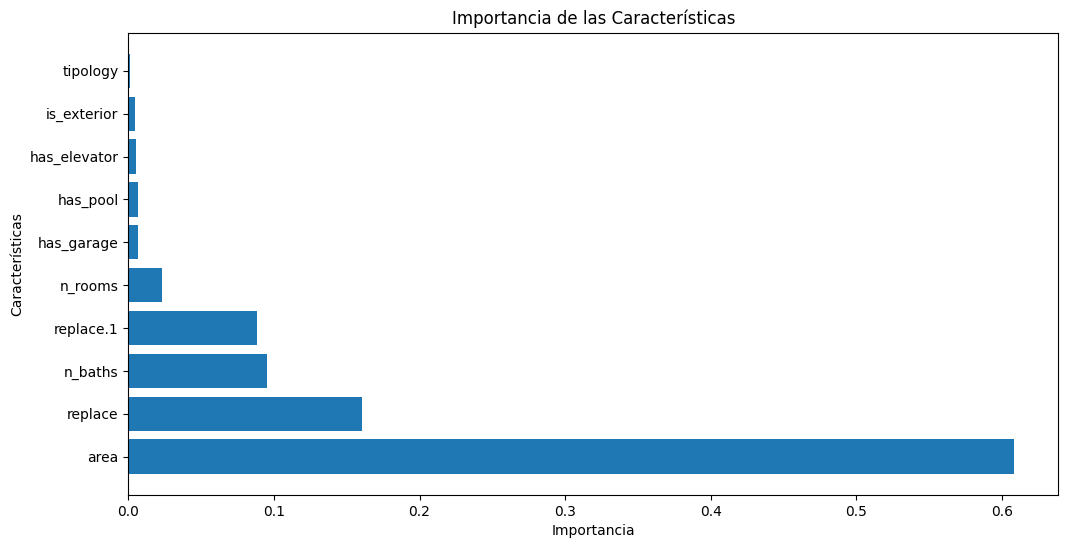

In [34]:
importances = modeloRFR.feature_importances_
feature_names = df1.columns.drop("local_price")  # Excluir la columna "local_price"

# Crear un DataFrame con las importancias y los nombres de las características
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar el DataFrame por importancia en orden descendente
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.show()
